This notebook loads the sleep-trained variational distribution, and evaluates its performance as a deblender. 

To fit the variational distribution, run 


> `python train_encoder.py`


In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import deblending_runjingdev.simulated_datasets_lib as simulated_datasets_lib
import deblending_runjingdev.psf_transform_lib as psf_transform_lib
import deblending_runjingdev.starnet_lib as starnet_lib

from deblending_runjingdev.which_device import device 

import json

np.random.seed(345)

In [2]:
np.random.seed(1615)
_ = torch.manual_seed(3124)

# Prepare simulator

In [3]:
# size of image 
slen = 7

### Load PSF

In [4]:
bands = [2, 3]

In [5]:
psfield_file = './../sdss_stage_dir/2583/2/136/psField-002583-2-0136.fit'
init_psf_params = psf_transform_lib.get_psf_params(
                                    psfield_file,
                                    bands = bands)

power_law_psf = psf_transform_lib.PowerLawPSF(init_psf_params.to(device))
psf_og = power_law_psf.forward().detach()

### Background

In [6]:
background = torch.zeros(len(bands), slen, slen, device = device)
background[0] = 686.
background[1] = 1123.

### Simulator

In [7]:
simulator = simulated_datasets_lib.StarSimulator(psf_og, slen, background, transpose_psf = False)

# Load starnet

In [8]:
star_encoder = starnet_lib.StarEncoder(slen = slen, 
                                        ptile_slen = slen, 
                                        step = slen,
                                        edge_padding = 0,
                                        n_bands = psf_og.shape[0],
                                        max_detections = 2)

In [9]:
star_encoder.load_state_dict(torch.load('./starnet',
                                   map_location=lambda storage, loc: storage))
star_encoder.eval(); 
star_encoder.to(device);

# Function to draw images

In [10]:
def draw_image_batch(delta, f0, flux_ratio, color1, n_samples = 100): 

    true_fluxes = torch.zeros(n_samples, 2, len(bands), device = device)
    
    # flux of first star; color = 0
    true_fluxes[:, 0, :] = f0
    
    # second star with variable flux and color
    true_fluxes[:, 1, 0] = f0 * flux_ratio
    true_fluxes[:, 1, 1] = true_fluxes[:, 1, 0] * 10**(color1 / 2.5)
    
    # center of the image
    init_loc = 3.0
    
    # true locations, delta pixels from the center
    true_locs = torch.zeros(n_samples, 2, 2)
    true_locs[:, 0, :] = torch.Tensor([init_loc - delta, init_loc - delta]) / (slen - 1)
    true_locs[:, 1, :] = torch.Tensor([init_loc + delta, init_loc + delta]) / (slen - 1)
    true_locs = true_locs.to(device)
    
    # two stars
    n_stars = (torch.ones(n_samples, device = device) * 2).long()
    
    # return simulated image
    return simulator.draw_image_from_params(locs = true_locs, fluxes = true_fluxes, n_stars=n_stars)

In [11]:
delta = 0.5
color1 = 2.0
f0 = 6000
flux_ratio = 1
n_samples = 100

## See if it deblends

In [12]:
_delta_vec = np.linspace(0, 1, 12)

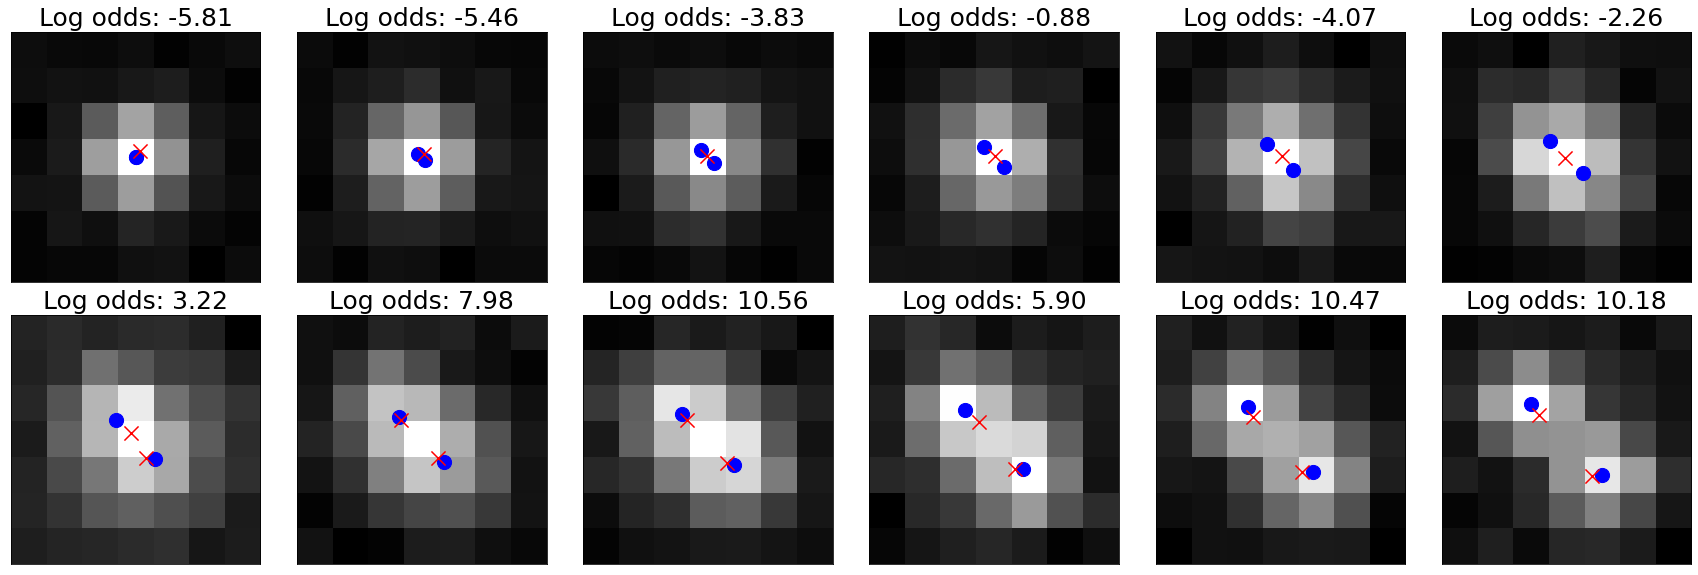

In [13]:
fig, axarr = plt.subplots(2, 6, figsize=(24, 8))

for i in range(len(_delta_vec)): 
    
    # get test image and plot
    full_image = draw_image_batch(_delta_vec[i], f0 = 4000., flux_ratio = 1, color1 = 0, n_samples=100)
    im = axarr[i // 6, i % 6].matshow(full_image[0, 0].cpu(), cmap = plt.cm.gray)
    axarr[i // 6, i % 6].set_yticks([])
    axarr[i // 6, i % 6].set_xticks([])
    
    # plot true locs
    true_locs = torch.zeros(2, 2)
    init_loc = 3.0
    true_locs[0, :] = torch.Tensor([init_loc - _delta_vec[i], init_loc - _delta_vec[i]]) / (slen - 1)
    true_locs[1, :] = torch.Tensor([init_loc + _delta_vec[i], init_loc + _delta_vec[i]]) / (slen - 1)
    axarr[i // 6, i % 6].scatter(true_locs[:, 1] * (slen - 1), 
           true_locs[:, 0] * (slen - 1), 
           color = 'blue', s = 200)

    
    # starnet results
    map_locs, _, _, _, log_probs = star_encoder.forward(full_image)
    indx = 0
    map_n_stars = log_probs[indx].argmax()
    map_locs = map_locs[indx].detach()
    axarr[i // 6, i % 6].scatter(map_locs.cpu()[0:map_n_stars, 1] * (slen - 1), 
                                   map_locs.cpu()[0:map_n_stars, 0] * (slen - 1), 
                                   color = 'red', marker = 'x', s = 200)
    
    title_str = 'Log odds: {:.02f}'.format(log_probs[indx, 2] - log_probs[indx, 1])
    axarr[i // 6, i % 6].set_title(title_str, fontsize = 25)
    
fig.tight_layout()

fig.savefig('../figures/deblending_example.png')